# DepMap CCL: Cohort Definition & Data Subsetting

**Objective**: Integrate multi-modal genomic and pharmacogenomic data to create an analysis-ready cancer cell line dataset.

---
---
---

## 1. Setup 📦

---
---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ptitprince as pt
import seaborn as sns

# Computational Modules
from scipy.stats import norm, spearmanr, zscore

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load and organize DepMap cell line metadata along with relevant drug response measures.

---
---

In [2]:
# Define project root and file path relative to user OS
BASE_DIR = Path.cwd()
CELL_LINE_MODELS_PATH       = BASE_DIR / 'data' / 'Models.csv'
PRISM_DRUG_RESPONSE_PATH    = BASE_DIR / 'data' / 'PRISMDrugResponse.csv'

In [3]:
# Load DepMap data into local dataframe (with disabled chunked dtype inference)
ccl_models_df               = pd.read_csv(CELL_LINE_MODELS_PATH, low_memory=False)
drug_response_df            = pd.read_csv(PRISM_DRUG_RESPONSE_PATH, low_memory=False)

The original datasets were downloaded from DepMap’s public [portal](https://depmap.org/portal/data_page/?tab=allData).

- **`ccl_models_df`**: Contains metadata describing all cancer cell line models from the DepMap portal. 

- **`drug_response_df`**: Contains drug response measurements for multiple compounds, including dose–response metrics.

**NOTE:** Cell line metadata were obtained from DepMap release 25Q3. PRISM secondary drug response data (20Q2) and CCLE mutation annotations (22Q2) were obtained from earlier DepMap releases, as these datasets are not updated every quarter. All datasets are harmonized using stable DepMap ModelIDs. Furthermore, only PRISM secondary screen data is used for drug response analyses, as it provides more reliable dose–response metrics, whereas the primary screen is intended for broader, exploratory use. 

## 3. PRISM Drug Response - Data Inspection, Subsetting, and Validation 💊

**Objective**: Define the drug response analysis cohort by selecting pre-approved PARP inhibitors, conduct cursory explorations, and execuate quality control measures. 

**Methodology**: First, the PRISM drug response dataset is filtered to retain PARPi drugs approved by the FDA and EMA. Second, validation checks are performed to ensure AUC values are within expected ranges, to examine goodness-of-fit, and to flag any missing cell lines. Third, quality control filters will be applied to ensure a high quality drug response dataset will be used in the study. Finally, the presence of multiple measurements per cell line–drug combination is assessed, and replicates are collapsed using the median AUC. The resulting dataset preserves relevant PARP inhibitors with relevant cell line biomarkers in long-format for downstream analyses.

---
---

There are currently four PARP inhibitors approved by both the U.S. Food and Drug Administration (FDA) and the European Medicines Agency (EMA): Olaparib (2014), Rucaparib (2016), Niraparib (2017), and Talazoparib (2018). This project will focus on these clinically approved agents when assessing drug response against HRD status. Therefore, the first step is to filter for these drugs before further explorations and preprocessing.

In [4]:
# Define list of approved PARP inhibitors
approved_parpi = [
    'olaparib',
    'rucaparib',
    'niraparib',
    'talazoparib'
]

# Filter for approved PARP inhibitors
parpi_df = drug_response_df[
    drug_response_df['name'].isin(approved_parpi)
].reset_index(drop=True)

In [5]:
# Inspect drug response data
parpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   broad_id              4467 non-null   object 
 1   depmap_id             4437 non-null   object 
 2   ccle_name             4407 non-null   object 
 3   screen_id             4467 non-null   object 
 4   upper_limit           4467 non-null   float64
 5   lower_limit           4467 non-null   float64
 6   slope                 4467 non-null   float64
 7   r2                    4467 non-null   float64
 8   auc                   4467 non-null   float64
 9   ec50                  4467 non-null   float64
 10  ic50                  2549 non-null   float64
 11  passed_str_profiling  4467 non-null   bool   
 12  row_name              4467 non-null   object 
 13  name                  4467 non-null   object 
 14  moa                   4467 non-null   object 
 15  target               

This dataset contains parameters derived from four-parameter log–logistic dose–response curve fitting applied to replicate-level viability measurements. Key variables relevant for downstream analysis are outlined below.

Primary:
- `depmap_id`: Unique cell line identifier (primary key for data merges)
- `name`: Name of an approved PARP inhibitor
- `auc`: Area under the dose–response curve (primary response metric; lower values indicate greater sensitivity)

Context:
- `target`: Gene target annotation for the compound
- `disease.area`: Therapeutic disease area classification
- `indication`: Specific clinical indication annotation
- `screen_id`: Identifier of experimental screening batch (potential source of replicate structure)

QC Indicators:
- `r2`: Represents how closely the measurements follow the fitted logistic curve (Goodness-of-fit)
- `passed_str_profiling`: Quality control flag for cell line identity validation

Based on the dataset summary above, there are 4467 total AUC measurements across the selected PARP inhibitors and screened cancer cell lines. These entries may include technical or batch-level replicates for the same cell line–drug combination and therefore require consolidation prior to analysis.

Furthermore, the `ic50` field contains substantial missingness and will not be used in this study. `AUC` will serve as the primary pharmacologic response metric. Additionally, there are 30 records without a `depmap_id` and therefore cannot be mapped to a specific cell line for lineage-based analyses. These will also be excluded prior to downstream integration. While some context-related features also have substantial missing data, these can be temporarily retained for initial explorations prior to the main analyses.

Next, the QC indicators will be inspected to determine any further subsetting.

In [6]:
# Inspect distribution of STR profiling flag
print('STR profiling value counts:')
print(parpi_df['passed_str_profiling'].value_counts(dropna=False))

# Filter to retain only STR-validated records
parpi_df = parpi_df[
    parpi_df['passed_str_profiling'] == True
].reset_index(drop=True)

# Confirm filtering results
print('\nAfter STR filtering:')
print(f'Remaining records: ', len(parpi_df))
print(f'Unique cell lines: ', parpi_df['depmap_id'].nunique())

STR profiling value counts:
passed_str_profiling
True     4407
False      60
Name: count, dtype: int64

After STR filtering:
Remaining records:  4407
Unique cell lines:  725


QC Filtering: STR Profiling Validation

The `passed_str_profiling` flag indicates whether short tandem repeat (STR) profiling confirmed the identity of the screened cell line. Records failing STR validation may reflect misidentified or contaminated models and are therefore excluded to preserve data integrity. Only entries with `passed_str_profiling` == True will be retained for downstream analyses.

Next, a similar inspection and filter will be executed using the provided R² value.

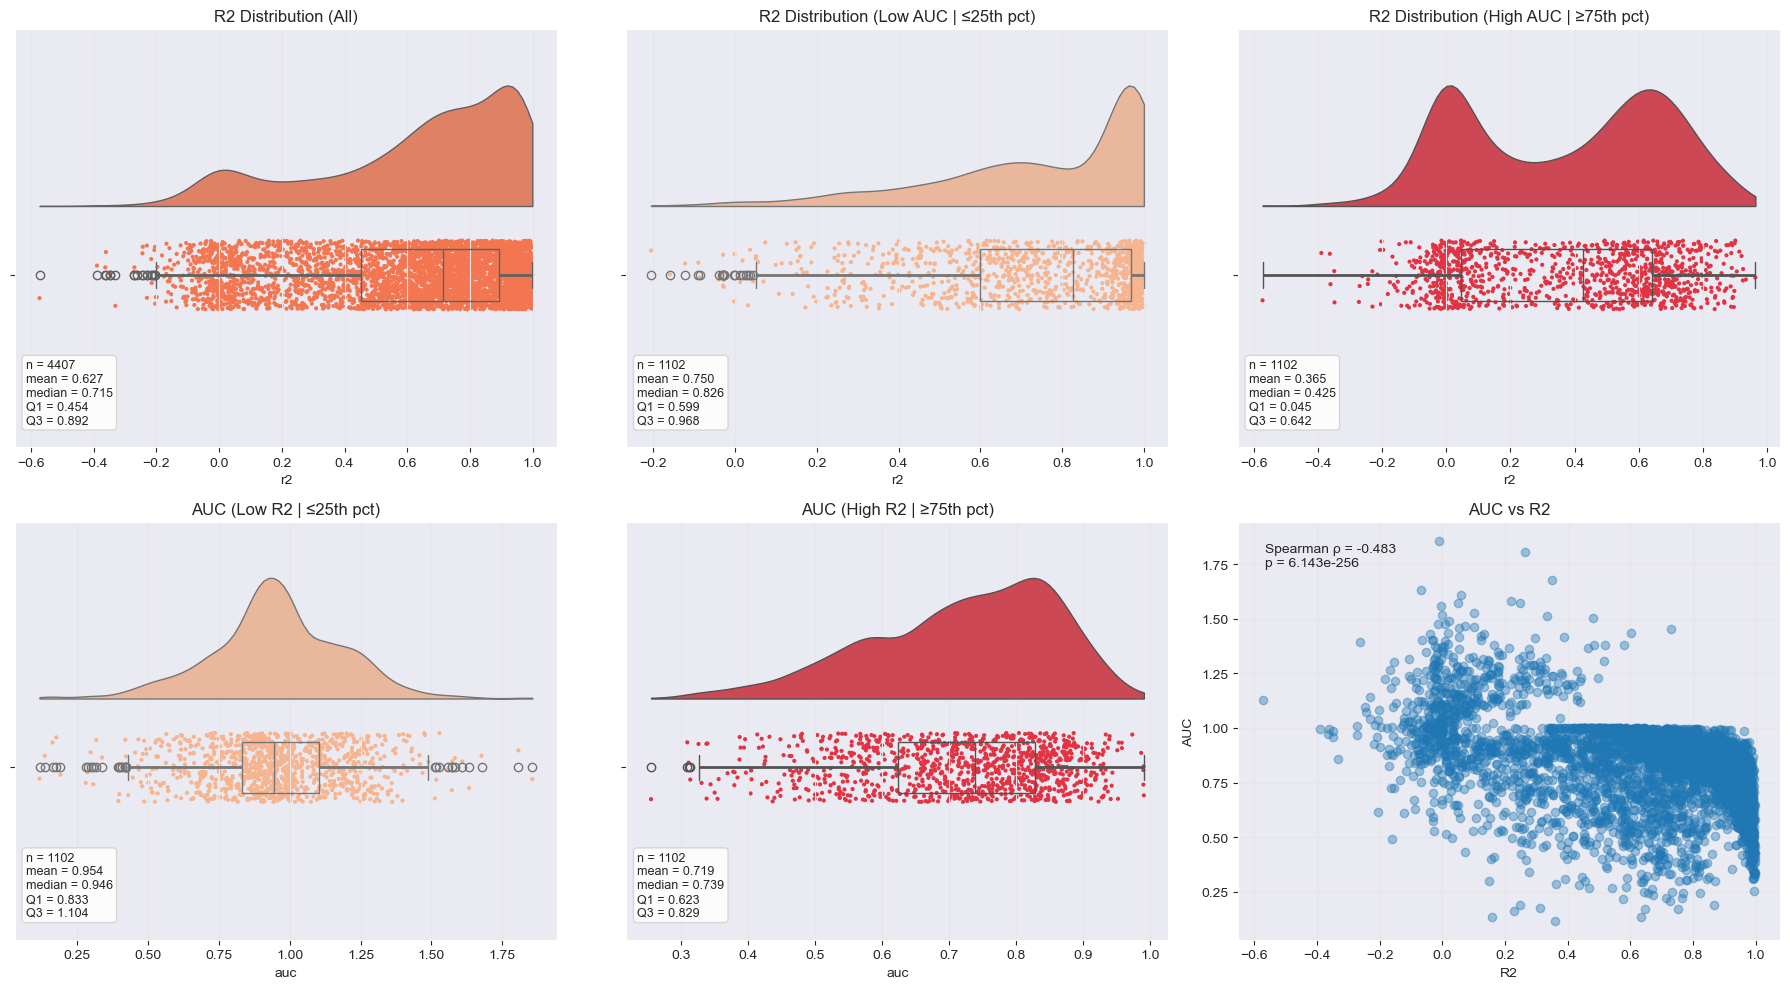

In [7]:
# Set up figure for aggregated R2 vs AUC analysis
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Subset data by low and high AUC / R2 for plots
low_auc_df = parpi_df[parpi_df['auc'] <= parpi_df['auc'].quantile(0.25)]
high_auc_df = parpi_df[parpi_df['auc'] >= parpi_df['auc'].quantile(0.75)]
low_r2_df = parpi_df[parpi_df['r2'] <= parpi_df['r2'].quantile(0.25)]
high_r2_df = parpi_df[parpi_df['r2'] >= parpi_df['r2'].quantile(0.75)]

# Plot R2 Distributions
pt.RainCloud(y='r2', data=parpi_df, ax=axs[0,0], palette=[sns.color_palette('rocket')[4]], hue=0, orient='h')
axs[0,0].set_title('R2 Distribution (All)')

pt.RainCloud(y='r2', data=low_auc_df, ax=axs[0,1], palette=[sns.color_palette('rocket')[5]], hue=0, orient='h')
axs[0,1].set_title('R2 Distribution (Low AUC | ≤25th pct)')

pt.RainCloud(y='r2', data=high_auc_df, ax=axs[0,2], palette=[sns.color_palette('rocket')[3]], hue=0, orient='h')
axs[0,2].set_title('R2 Distribution (High AUC | ≥75th pct)')

# Plot AUC Distributions
pt.RainCloud(y='auc', data=low_r2_df, ax=axs[1,0], palette=[sns.color_palette('rocket')[5]], hue=0, orient='h')
axs[1,0].set_title('AUC (Low R2 | ≤25th pct)')

pt.RainCloud(y='auc', data=high_r2_df, ax=axs[1,1], palette=[sns.color_palette('rocket')[3]], hue=0, orient='h')
axs[1,1].set_title('AUC (High R2 | ≥75th pct)')

# Plot correlation between R2 and AUC
axs[1,2].scatter(parpi_df['r2'], parpi_df['auc'], alpha=0.4)
axs[1,2].set_xlabel('R2')
axs[1,2].set_ylabel('AUC')
axs[1,2].set_title('AUC vs R2')
rho, pval = spearmanr(parpi_df['r2'], parpi_df['auc'])
axs[1,2].text(
    0.05, 0.95,
    f'Spearman ρ = {rho:.3f}\np = {pval:.3e}',
    transform=axs[1,2].transAxes,
    verticalalignment='top'
)

# Annotate summary stats on each distribution
def annotate_stats_bottom(ax, series):
    stats_text = (
        f'n = {len(series)}\n'
        f'mean = {series.mean():.3f}\n'
        f'median = {series.median():.3f}\n'
        f'Q1 = {series.quantile(0.25):.3f}\n'
        f'Q3 = {series.quantile(0.75):.3f}'
    )
    ax.text(
        0.02, 0.05,
        stats_text,
        transform=ax.transAxes,
        verticalalignment='bottom',
        horizontalalignment='left',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round', alpha=0.9
        )
    )
annotate_stats_bottom(axs[0,0], parpi_df['r2'])
annotate_stats_bottom(axs[0,1], low_auc_df['r2'])
annotate_stats_bottom(axs[0,2], high_auc_df['r2'])
annotate_stats_bottom(axs[1,0], low_r2_df['auc'])
annotate_stats_bottom(axs[1,1], high_r2_df['auc'])

plt.tight_layout()
plt.show()

R² (coefficient of determination) measures how well a model explains variability in observed data. It isn't a measure of drug effect size, but of model fit quality. For instance, a value close to 1 indicates that the fitted curve closely follows the observed data, whereas a value near 0 indicates that the model explains none of the observed variance (with <0 meaning the fit performs worse than a simple horizontal mean).

In this context, `r2` reflects how well the four-parameter log–logistic model fits the observed dose–response viability measurements for each cell line–drug pair. So a high value here indicates the response follows the expected sigmoidal pattern and that the curve parameters are likely reliable. On the other hand, a low value suggest poor fit, which may result from experimental noise, limited dynamic range, or deviation from a sigmoidal response.

As a quality control metric, the goal is to remove unreliable curve fits without introducing systematic bias. Importantly, low `r2` values do not always indicate technical failure. In cases of true biological resistance, viability may remain flat across all tested concentrations. Because the logistic model expects a dose-dependent decline, fitting a flat response can yield low or even negative R² values. Applying an arbitrary threshold could therefore disproportionately remove resistant cell lines, artificially enriching the dataset for sensitive responses, biasing towards the drug seeming more effective than it actually may be.

To evaluate this risk, the relationship between AUC and R² was examined by visualizing their distributions across response strata and calculating a correlation coefficient. The results show a moderate negative Spearman correlation (ρ ≈ −0.48, p <0.001), indicating that lower R² values are enriched among higher AUC (more resistant) observations. This confirms that aggressive R² filtering would preferentially exclude resistant models. Therefore, any R² threshold must be selected cautiously and justified empirically, balancing curve-fit reliability against preservation of true biological resistance signals.

Before applying any filters, it is also important to note that the AUC plots show values exceed 1 in some scenarios. This should be examined further.

Number of AUC measurements >1: 409

Summary statistics of subset with AUC>1
 count    409.000000
mean       1.189632
std        0.139362
min        1.000000
25%        1.087481
50%        1.172868
75%        1.263188
max        1.856211
Name: auc, dtype: float64

Summary statistics of R2 across AUC>1
 count    409.000000
mean       0.083736
std        0.160060
min       -0.573349
25%       -0.014319
50%        0.047815
75%        0.172483
max        0.731509
Name: r2, dtype: float64


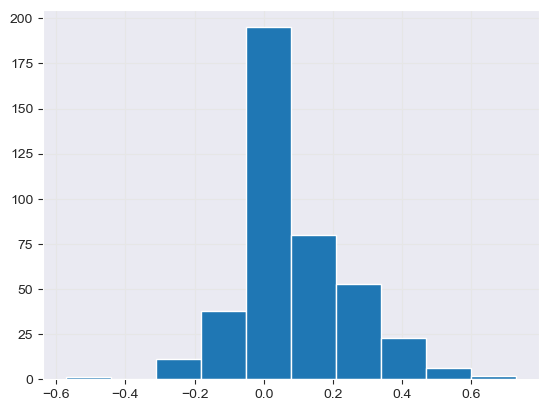

In [8]:
# Examine records of AUC>1
auc_over_one_df = parpi_df[parpi_df.auc > 1]
print('Number of AUC measurements >1:', len(auc_over_one_df))
print('\nSummary statistics of subset with AUC>1\n', auc_over_one_df.auc.describe())

# Examine R2 values across AUC>1 subset
r2_auc_over_1 = auc_over_one_df.r2
print('\nSummary statistics of R2 across AUC>1\n', r2_auc_over_1.describe())
r2_auc_over_1 = r2_auc_over_1.hist()
plt.show()

Before applying any QC filters or collapsing replicates, it is evident that a subset of AUC measurements exceed 1 (409/4407 records). These values are biologically implausible, as AUC represents fractional viability and should theoretically range from 0 to 1. The summary statistics show that many of these AUC > 1 values occur in curves with very low R² (median ≈ 0.048), indicating poor fit of the dose–response model.

AUC values above 1 can arise from technical or biological sources: minor baseline shifts or normalization noise in the curve-fitting process can mathematically push the integrated AUC above 1, and in rare cases, low-dose growth stimulation (“hormesis”) may transiently elevate viability readings. In the context of PARP inhibitors and PRISM screens, these high-AUC, low-R² cases are overwhelmingly technical artifacts rather than true resistance.

This combination of high AUC and low R² strongly suggests these records should be removed. Retaining them could skew downstream analyses, particularly replicate aggregation and HRD–PARPi correlations. Therefore, all AUC > 1 records will be removed along with the QC filtering, ensuring only biologically plausible and reliably modeled responses are included.

In [9]:
# Count records with negative R² or AUC > 1 before filtering
negative_r2_count = (parpi_df['r2'] < 0).sum()
auc_over_one_count = (parpi_df['auc'] > 1).sum()
total_records_before = len(parpi_df)
print(f'Negative R² records: {negative_r2_count}')
print(f'AUC > 1 records: {auc_over_one_count}')
print(f'Total records before filtering: {total_records_before}')

# Filter out records with negative R² or AUC > 1
parpi_df = parpi_df[
    (parpi_df['r2'] >= 0) & 
    (parpi_df['auc'] <= 1)
].reset_index(drop=True)

# Confirm filtering results
total_records_after = len(parpi_df)
print('\nAfter filtering (R² >= 0 and AUC <= 1):')
print('Remaining records: ', total_records_after)
print('Records removed: ', total_records_before - total_records_after)
print('Unique cell lines: ', parpi_df['depmap_id'].nunique())

Negative R² records: 273
AUC > 1 records: 409
Total records before filtering: 4407

After filtering (R² >= 0 and AUC <= 1):
Remaining records:  3868
Records removed:  539
Unique cell lines:  724


Since there is a moderate negative correlation between R² and AUC (Spearman ρ ≈ −0.48), lower R² values are enriched among more resistant (high AUC) responses. Applying an aggressive R² threshold alone could disproportionately exclude resistant cell lines and bias the dataset toward apparent sensitivity.

Additionally, a subset of AUC measurements exceed 1, which is biologically implausible. These high AUC values frequently occur in curves with very low R², indicating poor model fit and likely representing technical artifacts rather than true resistance. Retaining them could skew replicate aggregation and downstream HRD–PARPi analyses.

To preserve true biological resistance while removing objectively unreliable data, a minimal quality control strategy was implemented: **all records with R² < 0 and all records with AUC > 1 were excluded**, while non-negative R² values ≤ 1 were retained. After running an initial study, more stringent thresholds can be applied later to confirm the robustness of downstream conclusions.

Now that these QC filters have been applied, the remaining records can be collapsed across replicates to produce a single representative AUC per cell line–drug combination.

In [10]:
# Count replicates per cell line + drug
replicate_counts = (
    parpi_df
    .groupby(['depmap_id', 'name'])
    .size()
)

print('Replicate count summary:')
print(replicate_counts.describe())
print('\nCombinations with >1 replicates: ', (replicate_counts > 1).sum())

Replicate count summary:
count    2597.000000
mean        1.489411
std         0.730936
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
dtype: float64

Combinations with >1 replicates:  913


PRISM drug screens often include replicates (multiple rows per cell line and drug), arising from multiple wells per dose or even separate experimental runs altogether. Therefore, this must be accounted for before further explorations.

In [11]:
# Examine screening batch structure per cell line–drug pair
screen_counts = (
    parpi_df
    .groupby(['depmap_id', 'name'])['screen_id']
    .nunique()
)

print('Unique screen_id count per cell line–drug pair:')
print(screen_counts.describe())

Unique screen_id count per cell line–drug pair:
count    2597.000000
mean        1.461687
std         0.704224
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: screen_id, dtype: float64


To assess potential batch structure, the number of unique `screen_id` values was calculated for each cell line–drug pair. Most combinations were screened once, with a minority screened twice and very few three times. This indicates limited multi-batch replication, supporting the decision to collapse replicates across screens using the median without modeling screen-level effects explicitly.


In [12]:
### Validate annotation fields grouped by cell line + drug have same "first observed value" 
# # Check that annotation fields are constant within each drug
# annotation_check = (
#     parpi_df
#     .groupby('name')[['target', 'disease.area', 'indication']]
#     .nunique()
# )
# print(annotation_check)

# # Check of "0s" are coming from null values 
# print('\nNulls in disease.area:', parpi_df['disease.area'].isna().sum())
# print('Nulls in indication:', parpi_df['indication'].isna().sum())
# print('\nUnique values per drug:')
# print(parpi_df.groupby('name')[['disease.area', 'indication']].nunique())


# Collapse replicates using median AUC per cell line per drug
parpi_df = (
    parpi_df
    .groupby(['depmap_id', 'name'], as_index=False)
    .agg({
        'auc': 'median',
        'r2': 'median',
        'target': 'first',
        'disease.area': 'first',
        'indication': 'first'
    })
)

print(f'Shape: {parpi_df.shape}')
print(f'Unique cell lines: {parpi_df["depmap_id"].nunique()}')

Shape: (2597, 7)
Unique cell lines: 724


The median AUC was used to collapse replicates for each cell line and PARP inhibitor, providing a representative measure of drug response while minimizing the influence of outliers or experimental variability. This approach ensures that each cell line–drug combination has a single, robust AUC value for the purpose of this study.

Drug-level annotation fields (`target`, `disease.area`, and `indication`) were retained using the first observed value, as these attributes are constant for a given compound and do not vary across replicates (separately validated). This preserves relevant compound metadata while ensuring a single robust response value per cell line–PARP inhibitor pair.

In [13]:
parpi_df

,depmap_id,name,auc,r2,target,disease.area,indication
0,ACH-000001,niraparib,0.741783,0.876853,PARP1,oncology,primary peritoneal cancer (PPC)
1,ACH-000001,olaparib,0.916763,0.822464,"PARP1, PARP2",oncology,ovarian cancer
2,ACH-000001,rucaparib,0.828451,0.797532,"PARP1, PARP2",None,None
3,ACH-000001,talazoparib,0.537748,0.966008,PARP2,None,None
4,ACH-000004,niraparib,0.836072,0.982664,PARP1,oncology,primary peritoneal cancer (PPC)
...,...,...,...,...,...,...,...
2592,ACH-001751,talazoparib,0.916882,0.690542,PARP2,None,None
2593,ACH-001765,niraparib,0.803358,0.675247,PARP1,oncology,primary peritoneal cancer (PPC)
2594,ACH-001765,olaparib,0.750304,0.844105,"PARP1, PARP2",oncology,ovarian cancer
2595,ACH-001765,rucaparib,0.946800,0.596895,"PARP1, PARP2",None,None


## 4. Cell Line Metadata - Data Inspection, Subsetting, and Validation 🧪

**Objective**: Subset the cancer model cohort by relevant lineages, explore key features, and apply quality control measures. 

**Methodology**: First, DepMap cancer cell lines are filtered to retain lineages relevant to FDA- and EMA-approved PARP inhibitors. Second, validation checks are performed to ensure data integrity across key identifiers and lineage annotations. Third, quality control filters are applied to generate a high-quality cohort suitable for downstream analyses.

---
---

PARP inhibitors are currently approved and clinically used in four primary cancer types: breast, ovarian (including fallopian tube and primary peritoneal), prostate, and pancreatic cancers. This project focuses on these lineages to evaluate PARP inhibitor response in relation to HRD status, as other cancer types remain under active investigation. Because the objective is to examine established clinical lineage–treatment relationships in vitro, DepMap's CCL data will restricted to these relevant data prior to further exploration and preprocessing.

In [14]:
# Inspect cancer model data
ccl_models_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ModelID                   2132 non-null   object 
 1   PatientID                 2132 non-null   object 
 2   CellLineName              2132 non-null   object 
 3   StrippedCellLineName      2132 non-null   object 
 4   DepmapModelType           2132 non-null   object 
 5   OncotreeLineage           2119 non-null   object 
 6   OncotreePrimaryDisease    2132 non-null   object 
 7   OncotreeSubtype           2132 non-null   object 
 8   OncotreeCode              1909 non-null   object 
 9   PatientSubtypeFeatures    156 non-null    object 
 10  RRID                      1985 non-null   object 
 11  Age                       1704 non-null   float64
 12  AgeCategory               2132 non-null   object 
 13  Sex                       2109 non-null   object 
 14  PatientR

This dataset contains DepMap cancer cell lines with relevant biomarkers and contextual metadata. Key variables are noted below.  

**Primary**:  
- `ModelID`: Unique cell line identifier (primary key for merges)  
- `COSMICID`: COSMIC database ID; might be helpful for joining with HRD feature sets from external sources 
- `SangerModelID`: Sanger cell line ID; might be helpful for joining with HRD feature sets from external sources 
- `OncotreeLineage`: Model lineage (cancer-specific)  
- `OncotreePrimaryDisease`: Primary disease of the model  
- `OncotreeSubtype`: Disease subtype  

**Context**:  
- `DepmapModelType`: Model type identifier  
- `OncotreeCode`: Standardized Oncotree code; blank if unavailable  
- `Age` / `AgeCategory`: Patient age at sampling and category (Adult / Pediatric)
- `Sex`: Patient sex  
- `PatientRace`: Patient-reported race  
- `PrimaryOrMetastasis`: Site of tumor origin  
- `SampleCollectionSite`: Tissue collection site  
- `SourceType`: Model source (Commercial / Academic / Other)  
- `GrowthPattern`: Culture format (Adherent / Suspension / etc.)  
- `OnboardedMedia` / `FormulationID` / `SerumFreeMedia`: Details of culture conditions  
- `ModelSubtypeFeatures`: Curated molecular features  

The dataset contains 2132 cancer cell lines. Core lineage and identifier fields are largely complete and suitable for integration. Many contextual variables contain substantial missingness and will be reserved for exploratory analyses rather than the main analysis.

In [15]:
# Examine the available cancer types
display(ccl_models_df.OncotreeLineage.value_counts())

OncotreeLineage
Lymphoid                     263
Lung                         260
Skin                         150
CNS/Brain                    127
Esophagus/Stomach            104
Bowel                         99
Breast                        96
Head and Neck                 94
Soft Tissue                   93
Bone                          93
Myeloid                       88
Ovary/Fallopian Tube          75
Kidney                        74
Pancreas                      68
Peripheral Nervous System     60
Biliary Tract                 45
Fibroblast                    45
Uterus                        44
Bladder/Urinary Tract         39
Pleura                        36
Liver                         29
Cervix                        26
Thyroid                       25
Eye                           24
Prostate                      15
Normal                        13
Testis                        12
Ampulla of Vater               5
Vulva/Vagina                   5
Muscle                     

This dataset includes cell lines spanning all four clinically relevant lineages. However, earlier inspection identified a small number of missing values in `OncotreeLineage`. Because `OncotreePrimaryDisease` and `OncotreeSubtype` are more granular and seem to be complete, these fields will be examined to determine whether lineage assignments can be reliably inferred before subsetting.

In [16]:
# Subset models with missing lineage and inspect subtype annotations
missing_lineage_df = (
    ccl_models_df[
        ccl_models_df['OncotreeLineage'].isna()
    ][[
        'ModelID',
        'OncotreePrimaryDisease',
        'OncotreeSubtype'
    ]]
    .reset_index(drop=True)
)
print('Number of models with missing OncotreeLineage: ', len(missing_lineage_df))

display(missing_lineage_df)

Number of models with missing OncotreeLineage:  13


,ModelID,OncotreePrimaryDisease,OncotreeSubtype
0,ACH-001085,Non-Cancerous,Transformed cell line
1,ACH-003132,Non-Cancerous,Immortalized Human Intervertebral Disc Cartila...
2,ACH-003133,Non-Cancerous,Immortalized Human Chondrocytes
3,ACH-003134,Non-Cancerous,Immortalized Human Pancreatic Mesenchymal Stem...
4,ACH-003136,Non-Cancerous,Immortalized Human Chondrocytes
5,ACH-003147,Non-Cancerous,Immortalized Submandibular Gland Cells
6,ACH-003295,Non-Cancerous,Transformed cell line
7,ACH-003296,Non-Cancerous,Transformed cell line
8,ACH-003297,Non-Cancerous,Transformed cell line
9,ACH-003305,Non-Cancerous,Transformed cell line


All models with missing `OncotreeLineage` are annotated as `Non-Cancerous` in `OncotreePrimaryDisease`, with subtypes corresponding to transformed or immortalized normal cell lines. These are not tumor-derived cancer models and therefore fall outside the scope of this study. Because the objective is to evaluate PARP inhibitor response in malignant cell lines, these non-cancerous models will be excluded from further analysis.

In [17]:
# Filter out non-cancerous cell lines (also filters out missing lineages as shown above)
ccl_models_df = ccl_models_df[
    ccl_models_df['OncotreePrimaryDisease'] != 'Non-Cancerous'
].reset_index(drop=True)

All models with missing `OncotreeLineage` are annotated as `Non-Cancerous` and correspond to immortalized or transformed normal cell lines. These were excluded, as the objective of this study is to model PARP inhibitor response in malignant contexts. PARP inhibitors act through synthetic lethality in tumors with homologous recombination deficiency, a cancer-associated phenotype not expected in DNA repair–proficient normal cells. Additionally, non-cancerous models often exhibit distinct growth and metabolic characteristics that could distort AUC distributions and artificially broaden the resistant population.

In [18]:
# Restrict to clinically relevant PARPi lineages
relevant_lineages = [
    'Ovary/Fallopian Tube',
    'Pancreas',
    'Breast',
    'Prostate'
]

# Subset to relevant lineages
ccl_models_df = (ccl_models_df[
        ccl_models_df['OncotreeLineage'].isin(relevant_lineages)
    ].reset_index(drop=True))

print('Remaining models: ', len(ccl_models_df))
print('\nLineage counts after subsetting:')
print(ccl_models_df['OncotreeLineage'].value_counts())

Remaining models:  241

Lineage counts after subsetting:
OncotreeLineage
Breast                  92
Ovary/Fallopian Tube    74
Pancreas                67
Prostate                 8
Name: count, dtype: int64


In [19]:
# Validate duplicate records of cell lines
ccl_models_df['ModelID'].duplicated().sum()

0

No duplicate records in the cell line data, ensuring data integrity.

In [20]:
# Examine model drivation materials within the filtered dataset
print(ccl_models_df['ModelDerivationMaterial'].value_counts(dropna=False))

# Remove any PDX cell lines
ccl_models_df = ccl_models_df[
    ~ccl_models_df['ModelDerivationMaterial'].str.contains('PDX', case=False, na=False)
].reset_index(drop=True)

ModelDerivationMaterial
NaN    240
PDX      1
Name: count, dtype: int64


PDX-derived models were excluded to preserve biological and experimental consistency. Although labeled as cell lines, PDX-derived models originate from tumors passaged in mice and may undergo additional in vivo selection pressures that alter growth dynamics and DNA damage response behavior. Because this study aims to model intrinsic PARP inhibitor sensitivity in malignant cell lines under standardized in vitro conditions, inclusion of PDX-derived systems would introduce avoidable heterogeneity unrelated to HRD biology. Therefore, only conventional tumor-derived cell lines were retained for downstream analysis.

In [21]:
# Retain only metadata columns relevant for downstream analysis
columns_of_interest = [
    # Identifiers
    'ModelID',
    'COSMICID',
    'SangerModelID',
    
    # Lineage Annotation
    'OncotreeLineage',
    'OncotreePrimaryDisease',
    'OncotreeSubtype',
    
    # Patient Context
    'Age',
    'AgeCategory',
    'Sex',
    'PatientRace',
    
    # Bio Context
    'PrimaryOrMetastasis',
    'GrowthPattern',
]

# Subset dataframe
ccl_models_df = (
    ccl_models_df[columns_of_interest]
    .copy()
)

In [22]:
ccl_models_df

,ModelID,COSMICID,SangerModelID,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern
0,ACH-000001,905933.0,SIDM00105,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent
1,ACH-000013,NaN,SIDM00093,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,60.0,Adult,Female,caucasian,Metastatic,Adherent
2,ACH-000017,NaN,SIDM00897,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,43.0,Adult,Female,caucasian,Metastatic,Mixed
3,ACH-000019,905946.0,SIDM00148,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,69.0,Adult,Female,caucasian,Metastatic,Adherent
4,ACH-000022,NaN,SIDM00452,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,64.0,Adult,Female,NaN,Metastatic,Adherent
...,...,...,...,...,...,...,...,...,...,...,...,...
235,ACH-002951,NaN,NaN,Breast,Invasive Breast Carcinoma,Invasive Breast Carcinoma,NaN,Adult,Female,NaN,Primary,Dome
236,ACH-003019,NaN,NaN,Prostate,Prostate Neuroendocrine Carcinoma,Prostate Neuroendocrine Carcinoma,NaN,Adult,Male,NaN,NaN,Adherent
237,ACH-003429,NaN,NaN,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,NaN,Unknown,Unknown,unknown,Metastatic,Adherent
238,ACH-003430,NaN,NaN,Pancreas,Pancreatic Adenocarcinoma,Pancreatic Adenocarcinoma,NaN,Unknown,Male,NaN,Metastatic,Adherent


## 5. Dataset Integration & Export 💾

**Objective**: Merge cancer cell line metadata with PRISM drug response data into a single harmonized dataframe and export it as pickled files for downstream HRD feature engineering and subsequent PARP inhibitor response analyses.

---
---

In [23]:
# Merge PARPi AUC data into filtered cell line metadata
ccl_parpi_df = (
    ccl_models_df.merge(
        parpi_df,
        left_on='ModelID',
        right_on='depmap_id',
        how='inner'  # keep only cell lines present in both
    )
)

# Examine merged data
display(ccl_parpi_df.info())
print('\nNumber of unique cell lines: ', ccl_parpi_df.ModelID.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ModelID                 376 non-null    object 
 1   COSMICID                283 non-null    float64
 2   SangerModelID           310 non-null    object 
 3   OncotreeLineage         376 non-null    object 
 4   OncotreePrimaryDisease  376 non-null    object 
 5   OncotreeSubtype         376 non-null    object 
 6   Age                     341 non-null    float64
 7   AgeCategory             376 non-null    object 
 8   Sex                     376 non-null    object 
 9   PatientRace             241 non-null    object 
 10  PrimaryOrMetastasis     376 non-null    object 
 11  GrowthPattern           376 non-null    object 
 12  depmap_id               376 non-null    object 
 13  name                    376 non-null    object 
 14  auc                     376 non-null    fl

None


Number of unique cell lines:  106


The curated cell line metadata was merged with the processed PARPi response data to create an analysis-ready dataset. This merge ensures that only biologically relevant models are retained, while each cell line is annotated with its corresponding AUC measurements and QC-filtered curve-fit metrics.

The resulting dataset contains one row per cell line–drug combination, so a single cell line can appear multiple times if it was screened with more than one PARP inhibitor. After merging, 106 unique cell lines are represented across 376 total rows, reflecting coverage of the four clinically relevant drugs within the filtered lineages. Notably, some curated cell lines do not have corresponding PARPi measurements and are therefore excluded, ensuring all retained models have empirically measured drug responses.

By anchoring the dataset to validated, malignant cell lines with QC-passed response data, downstream analyses of HRD status versus PARP inhibitor response are focused on contexts where synthetic lethality is biologically meaningful.

In [24]:
# Reorder columns per convenience (and remove duplicate ID info after merge)
column_order = [
    'ModelID',
    'name',
    'auc',
    'OncotreeLineage',
    'OncotreePrimaryDisease',
    'OncotreeSubtype',
    'target',
    'Age',
    'AgeCategory',
    'Sex',
    'PatientRace',
    'PrimaryOrMetastasis',
    'GrowthPattern',
    'indication',
    'r2',
    'COSMICID',
    'SangerModelID',
]

# Subset dataframe
ccl_parpi_df = (
    ccl_parpi_df[column_order]
    .copy()
)

In [25]:
ccl_parpi_df

,ModelID,name,auc,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,target,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern,indication,r2,COSMICID,SangerModelID
0,ACH-000001,niraparib,0.741783,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,PARP1,60.0,Adult,Female,caucasian,Metastatic,Adherent,primary peritoneal cancer (PPC),0.876853,905933.0,SIDM00105
1,ACH-000001,olaparib,0.916763,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,"PARP1, PARP2",60.0,Adult,Female,caucasian,Metastatic,Adherent,ovarian cancer,0.822464,905933.0,SIDM00105
2,ACH-000001,rucaparib,0.828451,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,"PARP1, PARP2",60.0,Adult,Female,caucasian,Metastatic,Adherent,None,0.797532,905933.0,SIDM00105
3,ACH-000001,talazoparib,0.537748,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,PARP2,60.0,Adult,Female,caucasian,Metastatic,Adherent,None,0.966008,905933.0,SIDM00105
4,ACH-000013,niraparib,0.596983,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,PARP1,60.0,Adult,Female,caucasian,Metastatic,Adherent,primary peritoneal cancer (PPC),0.768993,NaN,SIDM00093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,ACH-000979,talazoparib,0.736700,Prostate,Prostate Adenocarcinoma,Prostate Adenocarcinoma,PARP2,69.0,Adult,Male,caucasian,Metastatic,Adherent,None,0.832637,905935.0,SIDM00120
372,ACH-001145,niraparib,0.821086,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,Serous Ovarian Cancer,PARP1,60.0,Adult,Female,NaN,Metastatic,Adherent,primary peritoneal cancer (PPC),0.803825,NaN,SIDM00219
373,ACH-001145,olaparib,0.938036,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,Serous Ovarian Cancer,"PARP1, PARP2",60.0,Adult,Female,NaN,Metastatic,Adherent,ovarian cancer,0.679592,NaN,SIDM00219
374,ACH-001145,rucaparib,0.915185,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,Serous Ovarian Cancer,"PARP1, PARP2",60.0,Adult,Female,NaN,Metastatic,Adherent,None,0.677656,NaN,SIDM00219


In [26]:
# Export merged data as reusable pickle file for HRD feature engineering
ccl_parpi_df.to_pickle(BASE_DIR / 'utils' / 'ccl_parpi_df.pkl')

The processed and merged dataset, containing QC-filtered PARP inhibitor responses and curated cell line metadata, is exported as a pickle file. This file serves as a reusable, analysis-ready input for downstream HRD feature engineering and analysis, preserving all relevant AUC measurements, curve-fit metrics, and cell line annotations.

## 6. Summary 📝

---
---


This notebook curated a cohort of cancer cell lines for PARP inhibitor response analyses. The PRISM drug response data was filtered to retain only clinically approved PARP inhibitors, minimal quality control was applied to remove poor curve fits and biologically implausible AUC values, and replicates were collapsed to obtain a robust measurement per cell line–drug pair.

Cell line metadata was restricted to malignant models from breast, ovarian/fallopian tube, prostate, and pancreatic lineages, excluding non-cancerous or otherwise irrelevant models.

The merged dataset links each validated cell line to its QC-filtered PARP inhibitor responses across the four relevant drugs, creating an analysis-ready resource for downstream HRD feature extraction. The dataset was exported as `ccl_parpi_df.pkl` to serve as the foundation for subsequent data engineering and statistical modeling pipelines.